# Rolling ball filter

- https://media.nature.com/original/nature-assets/srep/2016/160725/srep30179/extref/srep30179-s1.pdf
- https://github.com/imagej/imagej1/blob/master/ij/plugin/filter/BackgroundSubtracter.java
- http://ieeexplore.ieee.org/document/1654163/?reload=true

https://plot.ly/python/alpha-shapes/
>In a family of alpha shapes, the parameter α controls the level of detail of the associated alpha shape. If α decreases to zero, the corresponding alpha shape degenerates to the point set, S, while if it tends to infinity the alpha shape tends to the convex hull of the set S.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from scipy import spatial

<IPython.core.display.Javascript object>


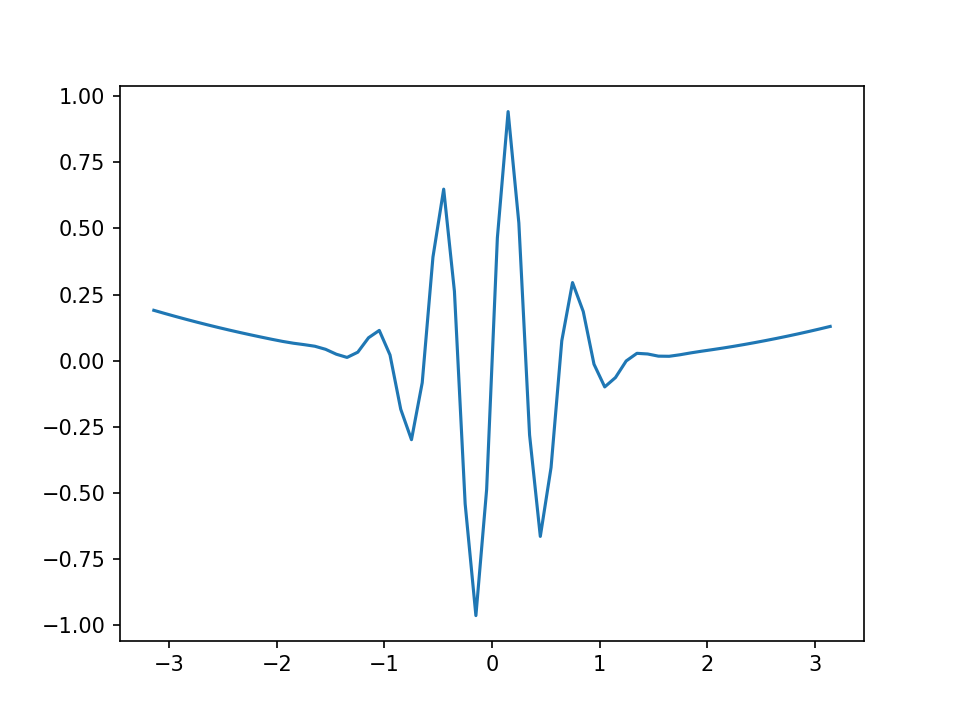

In [2]:
# generate fake data to play with
x= np.linspace(-1 * np.pi, 1 * np.pi, 64)
y = np.sin(10 * x)
y *= np.exp(-2 * x**2)
y += np.poly1d(np.random.randn(3))(x) * 0.01
plt.plot(x, y)

In [3]:
np.array((y, x)).shape

(2, 64)

In [4]:
# generate the Delaunay triangulation
d = spatial.Delaunay(np.array((x, y)).T)

In [5]:
d.vertices.shape

(122, 3)

In [6]:
d.simplices

array([[27, 33,  0],
       [29, 24, 30],
       [29, 25, 24],
       [14, 24, 17],
       [24, 14, 30],
       [34, 39, 33],
       [39, 34, 38],
       [30,  1,  0],
       [ 2,  1, 30],
       [ 1, 27,  0],
       [ 1,  2, 27],
       [ 4,  3, 30],
       [ 3,  2, 30],
       [27,  3,  4],
       [ 2,  3, 27],
       [ 8,  7, 30],
       [ 7,  6, 30],
       [27,  7,  8],
       [ 6,  7, 27],
       [ 5,  4, 30],
       [ 6,  5, 30],
       [ 5, 27,  4],
       [ 5,  6, 27],
       [ 9,  8, 30],
       [10,  9, 30],
       [ 9, 27,  8],
       [ 9, 10, 27],
       [12, 11, 30],
       [11, 10, 30],
       [27, 11, 12],
       [10, 11, 27],
       [25, 23, 24],
       [27, 26, 28],
       [26, 25, 28],
       [13, 12, 30],
       [14, 13, 30],
       [13, 27, 12],
       [13, 14, 27],
       [31, 35, 28],
       [25, 31, 28],
       [31, 25, 29],
       [31, 29, 30],
       [34, 32, 38],
       [32, 35, 38],
       [35, 32, 28],
       [32, 27, 28],
       [27, 32, 33],
       [32, 3

<IPython.core.display.Javascript object>


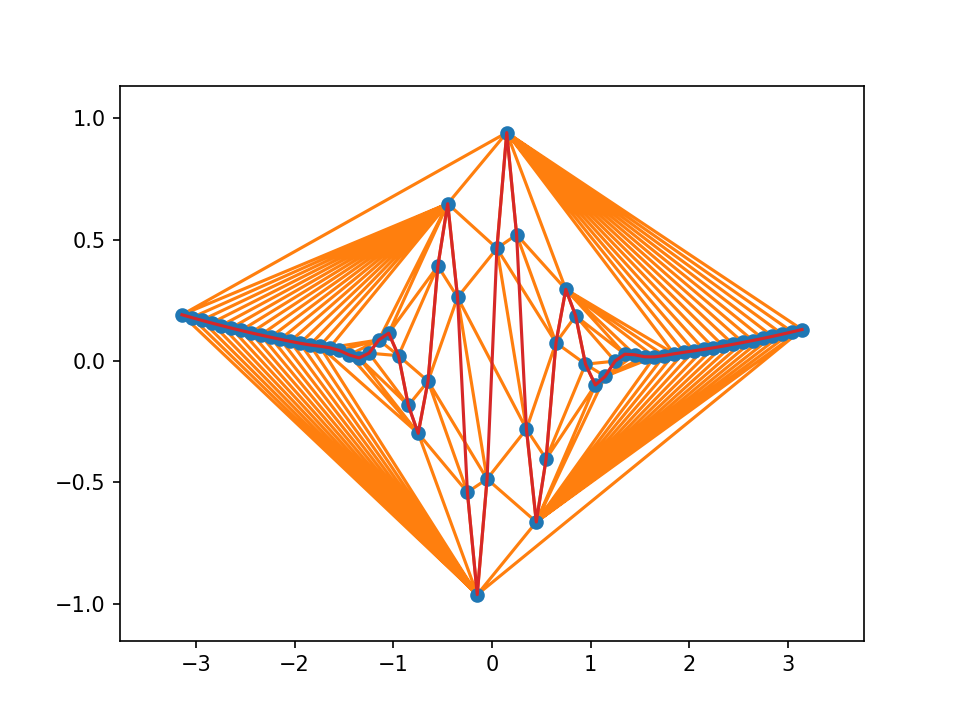

C:\Users\hoffmand\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\spatial\_plotutils.py:20: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  was_held = ax.ishold()


In [7]:
# plot to see triangles
fig, ax = plt.subplots()
spatial.delaunay_plot_2d(d, ax)
ax.plot(x, y)

In [8]:
def sq_norm(v):
    """squared norm""" 
    return np.linalg.norm(v)**2

Compute the circumcenter and circumradius of a triangle (see their definitions [here](https://en.wikipedia.org/wiki/Circumscribed_circle#Circumcircle_equations)):

In [9]:
def circumcircle(points,simplex):
    """Get the circumcenter and circum radius of all the simplices, works for 2D only
    
    Compute the circumcenter and circumradius of a triangle (see their definitions
    https://en.wikipedia.org/wiki/Circumscribed_circle#Circumcircle_equations)"""
    A=[points[simplex[k]] for k in range(3)]
    M=[[1.0]*4]
    M+=[[sq_norm(A[k]), A[k][0], A[k][1], 1.0 ] for k in range(3)] 
    M=np.asarray(M, dtype=float) 
    S=np.array([0.5*np.linalg.det(M[1:,[0,2,3]]), -0.5*np.linalg.det(M[1:,[0,1,3]])]) 
    a=np.linalg.det(M[1:, 1:]) 
    b=np.linalg.det(M[1:, [0,1,2]]) 
    return S/a,  np.array([np.sqrt(b/a+sq_norm(S)/a**2)]) #center=S/a, radius=np.sqrt(b/a+sq_norm(S)/a**2)

Filter the Delaunay triangulation to get the $\alpha$-complex:

In [10]:
def get_alpha_complex(alpha, points, simplexes):
    #alpha is the parameter for the alpha shape
    #points are given data points 
    #simplexes is the  list of indices in the array of points 
    #that define 2-simplexes in the Delaunay triangulation
    
    return filter(lambda simplex: circumcircle(points,simplex)[1] > alpha, simplexes)

In [11]:
def Plotly_data(points, complex_s):
    #points are the given data points, 
    #complex_s is the list of indices in the array of points defining 2-simplexes(triangles) 
    #in the simplicial complex to be plotted
    X=[]
    Y=[]
    for s in complex_s:
        X+=[points[s[k]][0] for k in [0,1,2,0]] #+[None]
        Y+=[points[s[k]][1] for k in [0,1,2,0]] #+[None]
    return X,Y    

In [12]:
def get_alpha_complex(alpha, points, simplexes):
    #alpha is the parameter for the alpha shape
    #points are given data points 
    #simplexes is the  list of indices in the array of points 
    #that define 2-simplexes in the Delaunay triangulation
    
    return filter(lambda simplex: circumcircle(points,simplex)[1] > alpha, simplexes)

In [13]:
def Plotly_data(alpha, points, simplices):
    #points are the given data points, 
    #complex_s is the list of indices in the array of points defining 2-simplexes(triangles) 
    #in the simplicial complex to be plotted
    centers, radii = np.array([circumcircle(points, s) for s in simplices]).T
    centers = np.vstack(centers)
    to_keep = radii > alpha
    p = points[simplices[to_keep]]
    above_right = p > centers[to_keep][:, None]
    return p, above_right

In [14]:
d.simplices[:3], d.points[:3]

(array([[27, 33,  0],
        [29, 24, 30],
        [29, 25, 24]], dtype=int32), array([[-3.14159265,  0.19034351],
        [-3.04185955,  0.17867486],
        [-2.94212645,  0.16735143]]))

In [15]:
d.points[d.simplices].shape

(122, 3, 2)

In [16]:
circumcircle(d.points, d.simplices[0])[1]

array([5.96433194])

In [17]:
np.concatenate(circumcircle(d.points, d.simplices[0]))

array([-2.76823629,  6.14297827,  5.96433194])

In [18]:
a = np.array([np.concatenate(circumcircle(d.points, s)) for s in d.simplices])
a.shape

(122, 3)

In [19]:
a, b = Plotly_data(0.5, d.points, d.simplices)

In [20]:
a.shape, b.shape

((84, 3, 2), (84, 3, 2))

In [21]:
pr = b.sum(1)[:,0] > 1
pa = b.sum(1)[:,1] > 1
pr, pa

(array([ True,  True,  True,  True, False,  True,  True, False, False,
         True,  True, False, False,  True,  True, False, False,  True,
         True, False, False,  True,  True, False, False,  True,  True,
        False, False,  True,  True, False, False,  True,  True,  True,
         True,  True,  True,  True, False, False,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
         True,  True, False, False, False, False, False, False, False,
         True, False,  True]),
 array([False,  True,  True,  True, False,  True,  True, False, False,
         True,  True, False, False,  True,  True, False, False,  True,
         True, False, False,  True,  True, False, False,  True,  True,
        False, False,  True,  True, False, False, False, False, False,
        False, False, False, False, False, Fal

In [22]:
np.vstack(a).shape

(252, 2)

In [23]:
np.unique(a[pa].reshape(-1, 2), axis=0)

array([[-3.14159265,  0.19034351],
       [-3.04185955,  0.17867486],
       [-2.94212645,  0.16735143],
       [-2.84239335,  0.15637319],
       [-2.74266025,  0.14573994],
       [-2.64292715,  0.13545154],
       [-2.54319405,  0.12550907],
       [-2.44346095,  0.1159166 ],
       [-2.34372785,  0.10667707],
       [-2.24399475,  0.09777168],
       [-2.14426165,  0.0891387 ],
       [-2.04452855,  0.08074118],
       [-1.94479545,  0.0728117 ],
       [-1.84506235,  0.06600671],
       [-1.74532925,  0.06062265],
       [-1.64559615,  0.05458463],
       [-1.54586305,  0.04299778],
       [-1.44612995,  0.02446116],
       [-1.34639685,  0.01230237],
       [-0.84773135, -0.18358746],
       [-0.74799825, -0.29845313],
       [-0.24933275, -0.54110077],
       [-0.14959965, -0.9631005 ],
       [ 0.44879895, -0.66390207],
       [ 0.54853205, -0.40366263],
       [ 1.04719755, -0.09911817],
       [ 1.14693065, -0.06376197],
       [ 1.44612995,  0.02534789],
       [ 1.54586305,

<IPython.core.display.Javascript object>


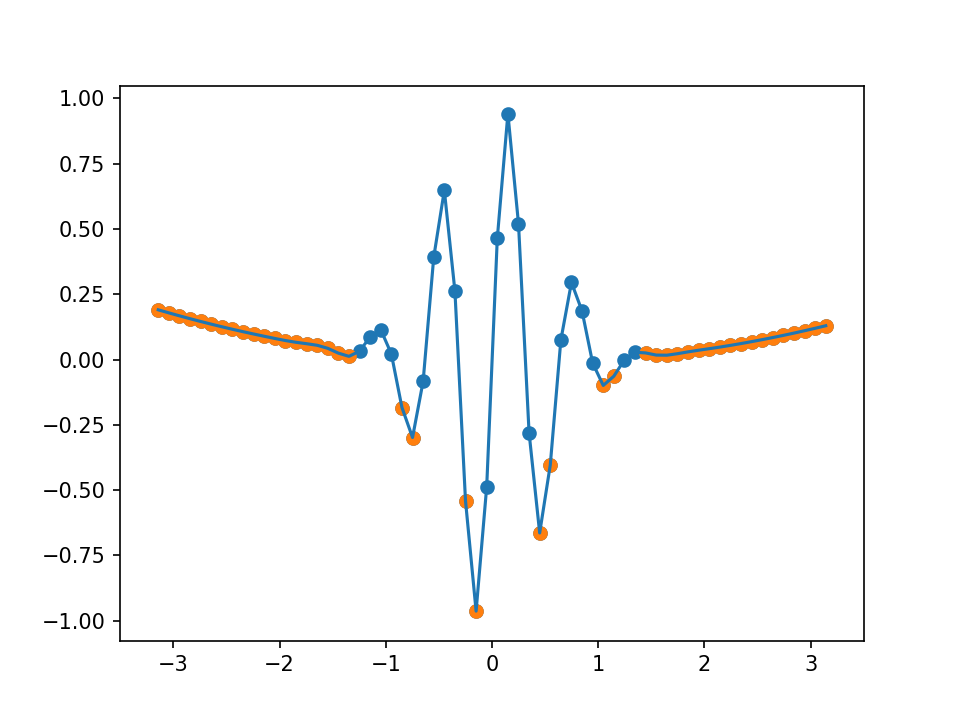

In [24]:
fig, ax = plt.subplots()
X, Y = np.unique(a[pa].reshape(-1, 2), axis=0).T
ax.scatter(x, y)
ax.scatter(X, Y)
ax.plot(x, y)

<IPython.core.display.Javascript object>


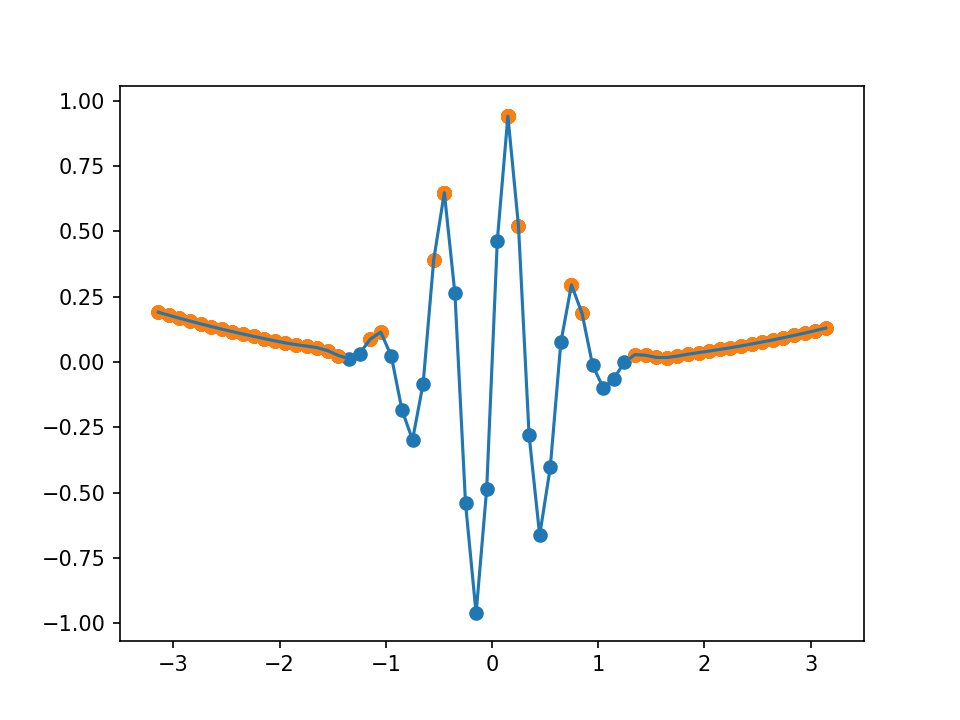

In [25]:
fig, ax = plt.subplots()
X, Y = a[~pa].reshape(-1, 2).T
ax.scatter(x, y)
ax.scatter(X, Y)
ax.plot(x, y)

<IPython.core.display.Javascript object>


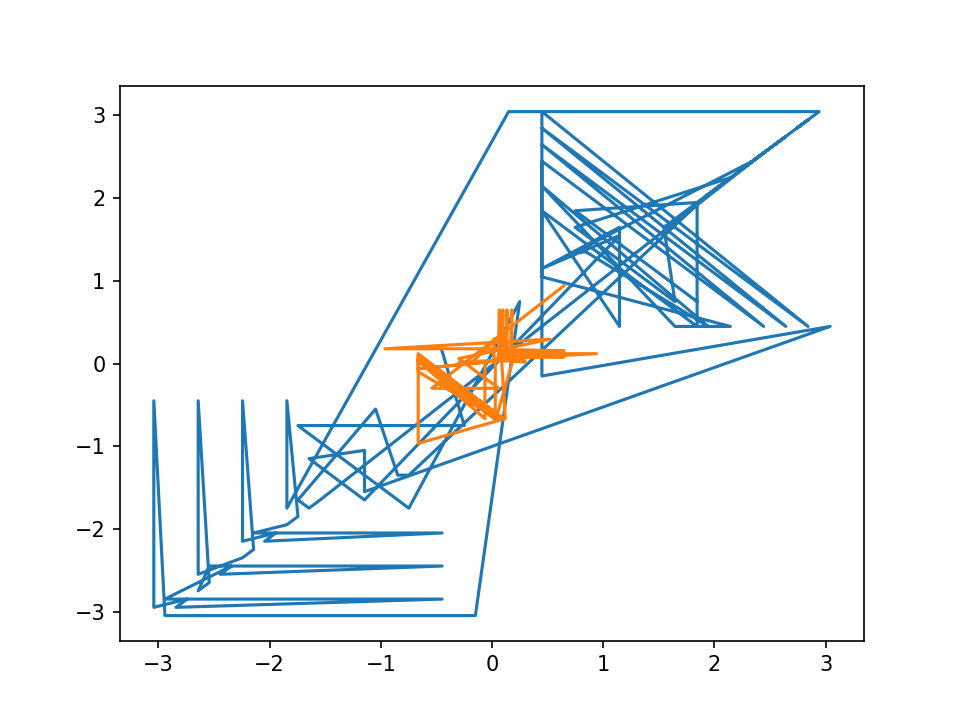

In [26]:
fig, ax = plt.subplots()
ax.plot(a[:, 0], a[:, 1])

<IPython.core.display.Javascript object>


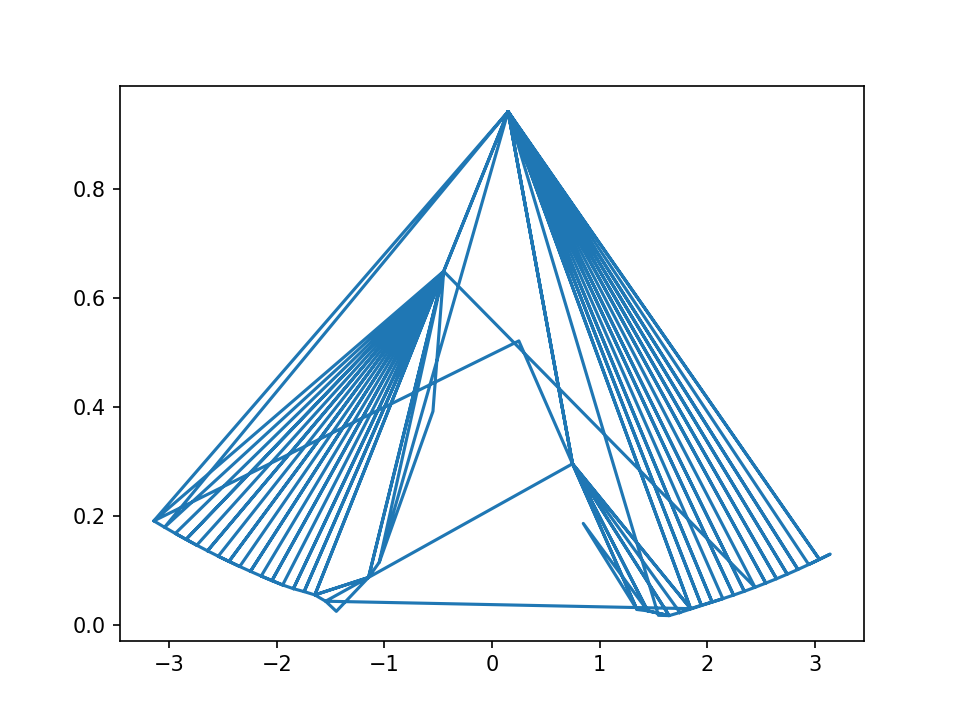

In [27]:
fig, ax = plt.subplots()
ax.plot(X, Y)

In [28]:
np.vstack((X, Y)).T

array([[-0.44879895,  0.64812013],
       [ 0.14959965,  0.94110467],
       [-3.14159265,  0.19034351],
       [ 0.24933275,  0.5204858 ],
       [ 0.74799825,  0.29509895],
       [ 0.14959965,  0.94110467],
       [-3.04185955,  0.17867486],
       [-0.44879895,  0.64812013],
       [-3.14159265,  0.19034351],
       [-3.04185955,  0.17867486],
       [-2.94212645,  0.16735143],
       [-0.44879895,  0.64812013],
       [-0.44879895,  0.64812013],
       [-2.84239335,  0.15637319],
       [-2.74266025,  0.14573994],
       [-2.94212645,  0.16735143],
       [-2.84239335,  0.15637319],
       [-0.44879895,  0.64812013],
       [-0.44879895,  0.64812013],
       [-2.44346095,  0.1159166 ],
       [-2.34372785,  0.10667707],
       [-2.54319405,  0.12550907],
       [-2.44346095,  0.1159166 ],
       [-0.44879895,  0.64812013],
       [-2.64292715,  0.13545154],
       [-0.44879895,  0.64812013],
       [-2.74266025,  0.14573994],
       [-2.64292715,  0.13545154],
       [-2.54319405,